In [1]:
import sys
from os.path import join as ospj

PROJECT_ROOT = '../..'
sys.path.append(ospj(PROJECT_ROOT, 'src'))

%load_ext autoreload
%autoreload 2

For this part of assignment 4, we'll use a simple CNN-LSTM architecture with a Resnet-152 backbone for image captioning. The CNN will be used to extract features from the images, and the LSTM will be used to decode the features into a sentence. The model is already pretrained from before. You'll just need to write the forward pass of the encoder and a sampling function for the lstm decoder to generate output captions.

For testing, we'll use 16 randomly sampled image-caption pairs from the [Microsoft COCO dataset](https://cocodataset.org/#home) which is the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers at Amazon Mechanical Turk. The sample image-caption pairs are available under `data/exercise-4/sample_image_caption_pairs.pkl` and the function for loading them is given in the code cell below.

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is done in `utils/build_vocab.py` and the corresponding vocabulary file is available under `data/exercise-4/vocab.pkl`.
There are a couple of special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since the models were trained with minibatches containing captions of different lengths, we pad short captions with a special `<pad>` token after the `<END>` token.

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from utils.utils import seed_everything

seed_everything(21)

with open('../../data/exercise-4/sample_image_caption_pairs.pkl', 'rb') as f:
    sample_image_caption_pairs = pickle.load(f)

def load_img_caption(dict, idx, transform=None):
    
    image = dict[idx]['img']
    caption = dict[idx]['caption']
    caption = caption.replace('<START>', '').replace('<END>', '')

    plt.imshow(image)
    plt.title(f'GT:{caption}')
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image, caption

## Downloading pre-trained weights

Please download the encoder and decoder weights [here](https://nextcloud.mpi-klsb.mpg.de/index.php/s/smxi7bxiGX67MYy), using the password `hlcv-ss23`. Place them under `saved/models/captioning/`. The file sizes are 35 MB and 225 MB respectively.

## Inference steps for CNN and LSTM (15 points)

There are overall 3 `TODOs` for this exercise. Write the forward pass for the CNN encoder in `models/captioning/cnn.py` and the inference and decoding steps for the lstm in `models/captioning/lstm.py`. For more details, please refer to the individual modules. The `forward` function provided for the lstm decoder cannot be used at inference time as it uses the ground truth captions as the input to the decoder at each timestep, and not the word it generated in the previous timestep. This is usual during training as this helps in faster convergence of the model. This is also known as `Teacher Forcing`. 

The code below is designed to work for a single input image and caption pair from the pickle file, but feel free to modify it to run for the entire batch of 16 pairs provided. 

Greedy approach:a sign that is sitting on a pole . . . .
Beam search approach:a close up of a stop sign and a stop sign . . .


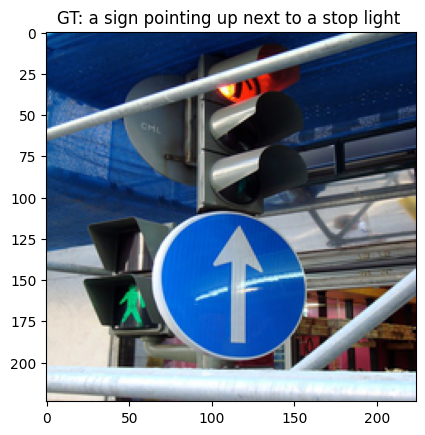

In [76]:
import torch
from torchvision import transforms

from utils.build_vocab import Vocabulary
from models.captioning.cnn import EncoderCNN
from models.captioning.lstm import DecoderLSTM


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embed_size = 256
hidden_size = 512
num_layers = 1

vocab_path = '../../data/exercise-4/vocab_fixed.pickle'
encoder_path = '../../saved/models/captioning/encoder-5-3000.pkl'
decoder_path = '../../saved/models/captioning/decoder-5-3000.pkl'

# Load vocabulary wrapper
# with open(vocab_path, 'rb') as f:
#     vocab = pickle.load(f)
vocab = Vocabulary()
with open(vocab_path, 'rb') as f:
    new_dicts = pickle.load(f)
    vocab.idx2word = new_dicts['i2w']
    vocab.word2idx = new_dicts['w2i']
    assert len(vocab.word2idx.keys()) == len(vocab.idx2word.keys())
    vocab.idx = len(vocab.word2idx.keys())

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

# Build models
encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
image, gt_caption = load_img_caption(sample_image_caption_pairs, np.random.choice(len(sample_image_caption_pairs)), transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)

sampled_ids = decoder.sample(feature)

sentence = decoder.decode_caption(sampled_ids, vocab)
print(f'Greedy approach:{sentence}')

sampled_ids_beam = decoder.sample_beam_search(feature, beam_width=3)
sentence_beam = decoder.decode_caption(sampled_ids_beam, vocab)
print(f'Beam search approach:{sentence_beam}')

### Comparing BLEU scores for Beam Search and Greedy Approaches (5 points)

The straightforward option while decoding with the lstm is to choose the word with the highest score at each step and use it to predict the next word. But this is not optimal because the rest of the sequence hinges on that first word you choose. If that choice isn't the best, everything that follows is sub-optimal. And it's not just the first word – each word in the sequence has consequences for the ones that succeed it. For example, the best possible sequence might include the second best word at the first step, third best word at the second step, and so on. So it's better to somehow not decide until we've finished decoding completely, and choose the sequence that has the highest overall score from a list of candidate sequences. This is the idea behind beam search. Beam Search is useful for any language modeling problem because it finds the most optimal sequence. 

However, you don't need to implement beam search for this exercise. It's already given in the LSTM decoder class. You can use the beam search implementation as hint for implementing the greedy search.

For evaluating model performance in captioning, BLEU (BiLingual Evaluation Understudy) score is a commonly used metric. This evaluates generated captions based on the n-grams (n consecutive words) that are present in the ground truth captions. The BLEU score is a number between 0 and 1, with 1 being the best possible score. The code block below computes the BLEU score for the generated caption. For more details on how BLEU score is calculated, you can refer to the official documentation in NLTK - `https://www.nltk.org/_modules/nltk/translate/bleu_score.html`.

If you implement the sample function in `models/captioning/lstm.py` correctly, you should ideally get a BLEU score comparable but slightly lower than that for beam search. But that may not always be the case. Also, usually, BLEU-1 score is the highest while BLEU-4 is the lowest for a given reference and ground truth caption pair. 

##### Trying out a few image-caption pairs before summary  

Greedy approach:a sign that is sitting on a pole . . . .

Greedy scores:

BLEU-1 score: 0.25
BLEU 2-score: 0.1507556722888818
BLEU 3-score: 0.08474477726954983
BLEU 4-score: 0.05284133043873052


Beam search approach (bw=3):a close up of a stop sign and a stop sign . . .

Beam Search scores (bw = 3): 

BLEU-1 score: 0.3571428571428572
BLEU 2-score: 0.165748386032949
BLEU 3-score: 0.08665324769349332
BLEU 4-score: 0.05188574832299887


Beam search approach (bw=5):a close up of a stop sign on a pole . . .

Beam Search scores (bw = 5): 

BLEU-1 score: 0.38461538461538464
BLEU 2-score: 0.17902871850985821
BLEU 3-score: 0.09295342576149437
BLEU 4-score: 0.05564101947390608


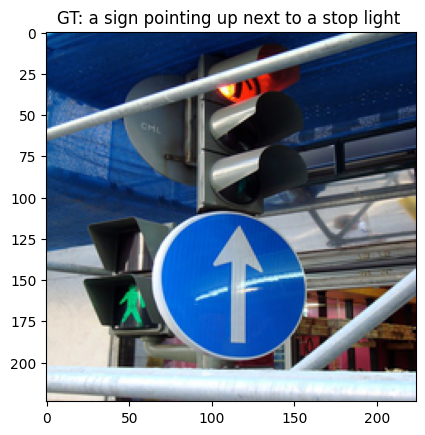

In [70]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# Prepare an image
image, gt_caption = load_img_caption(sample_image_caption_pairs, np.random.choice(len(sample_image_caption_pairs)), transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)

sampled_ids = decoder.sample(feature)

sentence = decoder.decode_caption(sampled_ids, vocab)
print(f'Greedy approach:{sentence}')

smoothie = SmoothingFunction().method4

reference = gt_caption.split()
candidate = sentence.split()

print('\nGreedy scores:\n')
print('BLEU-1 score: {}'.format(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)))
print('BLEU 2-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)))
print('BLEU 3-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)))
print('BLEU 4-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)))


beam_widths = [3,5]
for bw in beam_widths:

    sampled_ids_beam = decoder.sample_beam_search(feature, beam_width=bw)
    sentence_beam = decoder.decode_caption(sampled_ids_beam, vocab)
    print(f'\n\nBeam search approach (bw={bw}):{sentence_beam}')

    print(f'\nBeam Search scores (bw = {bw}): \n')

    smoothie = SmoothingFunction().method4

    reference = gt_caption.split()
    candidate = sentence_beam.split()

    print('BLEU-1 score: {}'.format(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)))
    print('BLEU 2-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)))
    print('BLEU 3-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)))
    print('BLEU 4-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)))

Greedy approach:a man sitting on a bench with a cat on his head . . .

Greedy scores:

BLEU-1 score: 0.2
BLEU 2-score: 0.11952286093343935
BLEU 3-score: 0.06859509393071936
BLEU 4-score: 0.04280703984817958


Beam search approach (bw=3):a woman sitting on a bench with a cat . . . .

Beam Search scores (bw = 3): 

BLEU-1 score: 0.23076923076923078
BLEU 2-score: 0.1386750490563073
BLEU 3-score: 0.07853356504598644
BLEU 4-score: 0.048970314286134506


Beam search approach (bw=5):a man is sitting on a bench in a park . . .

Beam Search scores (bw = 5): 

BLEU-1 score: 0.30769230769230765
BLEU 2-score: 0.22645540682891918
BLEU 3-score: 0.17007050142090102
BLEU 4-score: 0.10457138848650196


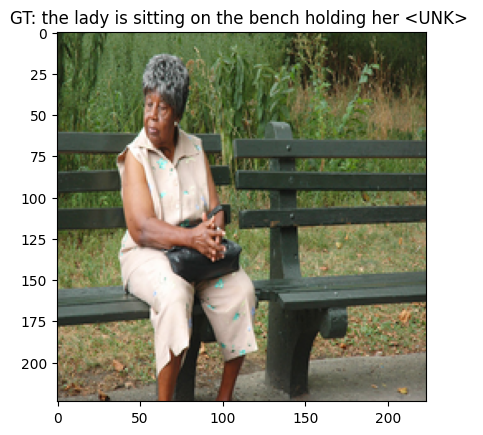

In [71]:
# Prepare an image
image, gt_caption = load_img_caption(sample_image_caption_pairs, np.random.choice(len(sample_image_caption_pairs)), transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)

sampled_ids = decoder.sample(feature)

sentence = decoder.decode_caption(sampled_ids, vocab)
print(f'Greedy approach:{sentence}')

smoothie = SmoothingFunction().method4

reference = gt_caption.split()
candidate = sentence.split()

print('\nGreedy scores:\n')
print('BLEU-1 score: {}'.format(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)))
print('BLEU 2-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)))
print('BLEU 3-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)))
print('BLEU 4-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)))


beam_widths = [3,5]
for bw in beam_widths:

    sampled_ids_beam = decoder.sample_beam_search(feature, beam_width=bw)
    sentence_beam = decoder.decode_caption(sampled_ids_beam, vocab)
    print(f'\n\nBeam search approach (bw={bw}):{sentence_beam}')

    print(f'\nBeam Search scores (bw = {bw}): \n')

    smoothie = SmoothingFunction().method4

    reference = gt_caption.split()
    candidate = sentence_beam.split()

    print('BLEU-1 score: {}'.format(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)))
    print('BLEU 2-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)))
    print('BLEU 3-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)))
    print('BLEU 4-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)))

Greedy approach:a man is jumping a skateboard on a ramp . . . .

Greedy scores:

BLEU-1 score: 0.46153846153846156
BLEU 2-score: 0.33968311024337877
BLEU 3-score: 0.1418551885701498
BLEU 4-score: 0.07664268377057176


Beam search approach (bw=3):a man riding a skate board at a skate park . . .

Beam Search scores (bw = 3): 

BLEU-1 score: 0.23076923076923078
BLEU 2-score: 0.0702324349442283
BLEU 3-score: 0.0398759843143497
BLEU 4-score: 0.024642660404143705


Beam search approach (bw=5):a man is doing a trick on a skateboard . . . .

Beam Search scores (bw = 5): 

BLEU-1 score: 0.38461538461538464
BLEU 2-score: 0.25318484177091666
BLEU 3-score: 0.1830666761913796
BLEU 4-score: 0.11057078116370667


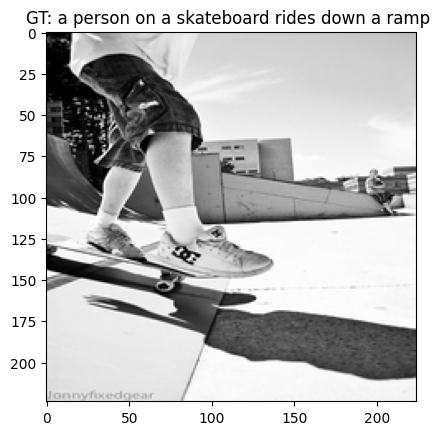

In [74]:
# Prepare an image
image, gt_caption = load_img_caption(sample_image_caption_pairs, np.random.choice(len(sample_image_caption_pairs)), transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)

sampled_ids = decoder.sample(feature)

sentence = decoder.decode_caption(sampled_ids, vocab)
print(f'Greedy approach:{sentence}')

smoothie = SmoothingFunction().method4

reference = gt_caption.split()
candidate = sentence.split()

print('\nGreedy scores:\n')
print('BLEU-1 score: {}'.format(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)))
print('BLEU 2-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)))
print('BLEU 3-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)))
print('BLEU 4-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)))


beam_widths = [3,5]
for bw in beam_widths:

    sampled_ids_beam = decoder.sample_beam_search(feature, beam_width=bw)
    sentence_beam = decoder.decode_caption(sampled_ids_beam, vocab)
    print(f'\n\nBeam search approach (bw={bw}):{sentence_beam}')

    print(f'\nBeam Search scores (bw = {bw}): \n')

    smoothie = SmoothingFunction().method4

    reference = gt_caption.split()
    candidate = sentence_beam.split()

    print('BLEU-1 score: {}'.format(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)))
    print('BLEU 2-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)))
    print('BLEU 3-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)))
    print('BLEU 4-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)))

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu
# from nltk.translate.bleu_score import SmoothingFunction

# smoothie = SmoothingFunction().method4

# reference = gt_caption.split()
# candidate = sentence.split()

# print('BLEU-1 score: {}'.format(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)))
# print('BLEU 2-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)))
# print('BLEU 3-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)))
# print('BLEU 4-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)))

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu
# from nltk.translate.bleu_score import SmoothingFunction

# smoothie = SmoothingFunction().method4

# reference = gt_caption.split()
# candidate = sentence_beam.split()

# print('BLEU-1 score: {}'.format(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)))
# print('BLEU 2-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)))
# print('BLEU 3-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)))
# print('BLEU 4-score: {}'.format(sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)))

Summarize your observations for different beam widths and image-caption pairs here:

We tried beam widths of 3 and 5 on several image-caption pairs. 3 of such pairs and their corresponding results are reported in the above cells.  
- In general, we observed that increasing the beam widths optimize our BLEU scores as we keep a higher number of potential candidate words, of course at the cost of more computation.  
- The beam search, as expected, gives better BLEU scores in most cases than the greedy search. But there are exceptions such as the last pair above (man on a skateboard), where our greedy search was able to achieve a better global average precision (and consequently BLEU) by giving more relevant tokens in its caption ('ramp' in this case), compared to the beam search outputs.